# GP kernel parameter optimization/ inference 

Slightly modified from 

https://tinygp.readthedocs.io/en/latest/tutorials/modeling.html

* Decouple train and test parts of the models
* Explicitely use `x` and `y` variables by passing them as function arguments rather than using them globally.

In [1]:
%%capture
try:
    from tinygp import kernels, GaussianProcess
except ModuleNotFoundError:
    %pip install -qq tinygp
    from tinygp import kernels, GaussianProcess

try:
    import numpyro
except ModuleNotFoundError:
    %pip uninstall -y jax jaxlib
    %pip install -qq jax jaxlib numpyro
    import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

try:
    import arviz
except ModuleNotFoundError:
    %pip install -qq arviz
    import arviz

try:
    import flax.linen as nn
except ModuleNotFoundError:
    %pip install -qq flax
    import flax.linen as nn
from flax.linen.initializers import zeros

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax

try:
    import blackjax
except ModuleNotFoundError:
    %pip install -qq jaxopt blackjax
    import blackjax

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

try:
    import arviz as az
except ModuleNotFoundError:
    %pip install -qq arviz
    import arviz as az

try:
    import tensorflow_probability.substrates.jax as tfp
except ModuleNotFoundError:
    %pip install tensorflow-probability
    import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
pml.latexify(width_scale_factor=2, fig_height=2)

/home/patel_zeel/miniconda3/envs/pyprobml/lib/python3.7/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


# Data


/home/patel_zeel/miniconda3/envs/pyprobml/lib/python3.7/site-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


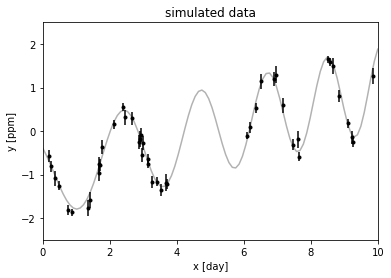

In [3]:
random = np.random.default_rng(42)

t = np.sort(
    np.append(
        random.uniform(0, 3.8, 28),
        random.uniform(5.5, 10, 18),
    )
)
yerr = random.uniform(0.08, 0.22, len(t))
y = 0.2 * (t - 5) + np.sin(3 * t + 0.1 * (t - 5) ** 2) + yerr * random.normal(size=len(t))

true_t = np.linspace(0, 10, 100)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

x = t
x_test = true_t
y_test = true_y

plt.figure()
plt.plot(x_test, y_test, "k", lw=1.5, alpha=0.3)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")

pml.savefig("gp-kernel-opt-data")



# Optimizing hyper-parameters using flax & optax

We  find the maximum (marginal) likelihood hyperparameters for the GP model.


To set up our model, we define a custom `linen.Module`, and optimize it's parameters as follows:

In [4]:
class GPModule(nn.Module):
    @nn.compact
    def __call__(self, x):
        # t = test input locations
        # Returns loss (-log p(y|x)) and predictions p(y|t)
        mean = self.param("mean", zeros, ())
        log_jitter = self.param("log_jitter", zeros, ())

        log_sigma1 = self.param("log_sigma1", zeros, ())
        log_rho1 = self.param("log_rho1", zeros, ())
        log_tau = self.param("log_tau", zeros, ())
        kernel1 = jnp.exp(2 * log_sigma1) * kernels.ExpSquared(jnp.exp(log_tau)) * kernels.Cosine(jnp.exp(log_rho1))

        log_sigma2 = self.param("log_sigma2", zeros, ())
        log_rho2 = self.param("log_rho2", zeros, ())
        kernel2 = jnp.exp(2 * log_sigma2) * kernels.Matern32(jnp.exp(log_rho2))

        kernel = kernel1 + kernel2
        gp = GaussianProcess(kernel, x, diag=jnp.exp(log_jitter), mean=mean)

        return gp


def loss(params, x, y):
    gp = model.apply(params, x)
    return -gp.log_probability(y)

CPU times: user 15.2 s, sys: 29.1 s, total: 44.3 s
Wall time: 2.42 s


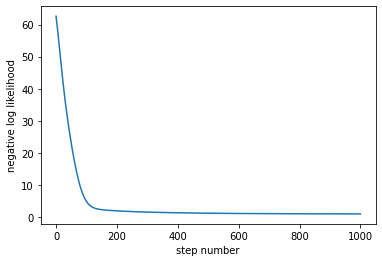

In [5]:
%%time
model = GPModule()
params = model.init(jax.random.PRNGKey(0), x)
tx = optax.sgd(learning_rate=3e-3)
opt_state = tx.init(params)
loss_grad_fn = jax.jit(jax.value_and_grad(loss))

losses = []
for i in range(1001):
    loss_val, grads = loss_grad_fn(params, x, y)
    losses.append(loss_val)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

plt.figure()
plt.plot(losses)
plt.ylabel("negative log likelihood")
_ = plt.xlabel("step number")

Our `Module` defined above also returns the conditional predictions, that we can compare to the true model:

/home/patel_zeel/miniconda3/envs/pyprobml/lib/python3.7/site-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


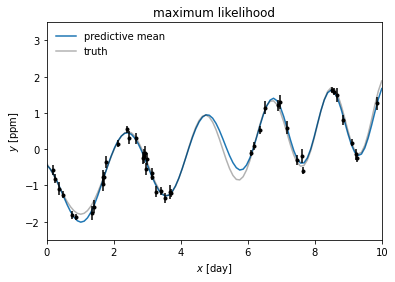

In [6]:
gp = model.apply(params, x)
pred = gp.condition(y, x_test).gp.loc

plt.figure()
plt.plot(x_test, pred, label="predictive mean")
plt.plot(x_test, y_test, "k", lw=1.5, alpha=0.3, label="truth")
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("$x$ [day]")
plt.ylabel("$y$ [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 3.5)
plt.legend(loc="upper left", frameon=False)
_ = plt.title("maximum likelihood")
pml.savefig("gp-kernel-opt-eb")


# Inferring hyper-parameters using NUTS in numpyro

We can compute a posterior over the kernel parameters, and hence the posterior predictive over the mean function, using NUTS.

In [7]:
prior_sigma = 5.0


def numpyro_model(x, y, x_test_inputs=None):
    mean = numpyro.sample("mean", dist.Normal(0.0, prior_sigma))
    jitter = numpyro.sample("jitter", dist.HalfNormal(prior_sigma))

    sigma1 = numpyro.sample("sigma1", dist.HalfNormal(prior_sigma))
    rho1 = numpyro.sample("rho1", dist.HalfNormal(prior_sigma))
    tau = numpyro.sample("tau", dist.HalfNormal(prior_sigma))
    kernel1 = sigma1**2 * kernels.ExpSquared(tau) * kernels.Cosine(rho1)

    sigma2 = numpyro.sample("sigma2", dist.HalfNormal(prior_sigma))
    rho2 = numpyro.sample("rho2", dist.HalfNormal(prior_sigma))
    kernel2 = sigma2**2 * kernels.Matern32(rho2)

    kernel = kernel1 + kernel2
    gp = GaussianProcess(kernel, x, diag=jitter, mean=mean)
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)


nuts_kernel = NUTS(numpyro_model, dense_mass=True, target_accept_prob=0.9)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=200,
    num_samples=500,
    num_chains=2,
    progress_bar=True,
    chain_method="vectorized",
)
rng_key = jax.random.PRNGKey(34923)

In [8]:
%%time
mcmc.run(rng_key, x, y, x_test)
samples = mcmc.get_samples()

sample: 100%|██████████| 700/700 [00:25<00:00, 27.99it/s]


CPU times: user 30 s, sys: 3.96 s, total: 34 s
Wall time: 28.7 s


Let's examine the posterior. 
For that task, let's use [`ArviZ`](https://arviz-devs.github.io):

In [9]:
data = az.from_numpyro(mcmc)
az.summary(data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
jitter,0.017,0.005,0.010,0.025,0.000,0.000,694.0,625.0,1.00
mean,-0.081,1.546,-2.691,3.302,0.075,0.053,487.0,371.0,1.00
rho1,2.410,1.205,1.838,3.556,0.134,0.095,159.0,75.0,1.01
rho2,7.389,3.362,2.045,13.684,0.135,0.096,548.0,546.0,1.01
sigma1,1.096,0.549,0.449,2.077,0.028,0.019,499.0,435.0,1.00
sigma2,1.786,1.121,0.425,4.113,0.057,0.041,455.0,537.0,1.00
tau,2.320,1.074,0.673,4.401,0.073,0.052,165.0,118.0,1.00


Now, let us sample posterior means for the test data

In [10]:
def sample_mean(samples, x, y, x_test):
    kernel1 = samples["sigma1"] ** 2 * kernels.ExpSquared(samples["tau"]) * kernels.Cosine(samples["rho1"])
    kernel2 = samples["sigma2"] ** 2 * kernels.Matern32(samples["rho2"])

    kernel = kernel1 + kernel2
    gp = GaussianProcess(kernel, x, diag=samples["jitter"], mean=samples["mean"])
    predictive = Predictive(numpyro_model, posterior_samples=samples)
    gp_samples = predictive(rng_key, x, y)
    return gp.condition(gp_samples["gp"], x_test).gp.loc


pred_numpyro = jax.vmap(sample_mean, in_axes=(0, None, None, None))(samples, x, y, x_test)

And, finally we can plot our posterior inferences of the comditional process, compared to the true model:

/home/patel_zeel/miniconda3/envs/pyprobml/lib/python3.7/site-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


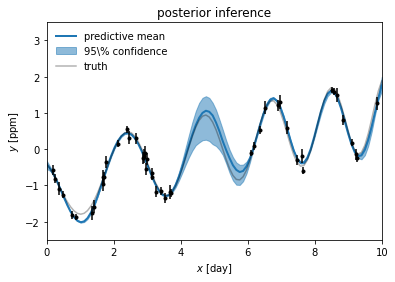

In [11]:
def plot_with_confidence(pred, name):
    q = np.percentile(pred, [5, 50, 95], axis=0)
    plt.figure()
    plt.plot(x_test, q[1], color="C0", lw=2, label="predictive mean")
    plt.fill_between(x_test, q[0], q[2], color="C0", alpha=0.5, label="95\% confidence")
    plt.plot(x_test, y_test, "k", lw=1.5, alpha=0.3, label="truth")

    plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
    plt.xlabel("$x$ [day]")
    plt.ylabel("$y$ [ppm]")
    plt.xlim(0, 10)
    plt.ylim(-2.5, 3.5)
    plt.legend(frameon=False, loc="upper left")
    _ = plt.title("posterior inference")
    pml.savefig(name)


plot_with_confidence(pred_numpyro, "gp-kernel-opt-hmc")

# Inferring hyper-parameters using NUTS in BlackJAX

* Inspired by [a blackjax documentation example](https://blackjax-devs.github.io/blackjax/examples/Introduction.html#nuts).

In [12]:
def log_joint(params, x=x, y=y):
    prior_sigma = 5.0
    log_probs = []
    log_probs.append(tfd.Normal(0, prior_sigma).log_prob(params["mean"]))
    for param in ["jitter", "sigma1", "rho1", "tau", "sigma2", "rho2"]:
        log_probs.append(tfd.HalfNormal(prior_sigma).log_prob(params[param]))

    kernel1 = params["sigma1"] ** 2 * kernels.ExpSquared(params["tau"]) * kernels.Cosine(params["rho1"])
    kernel2 = params["sigma2"] ** 2 * kernels.Matern32(params["rho2"])

    kernel = kernel1 + kernel2
    gp = GaussianProcess(kernel, x, diag=params["jitter"], mean=params["mean"])
    log_likelihood = gp.log_probability(y)
    log_prior = sum(log_probs)
    return log_likelihood + log_prior

In [13]:
initial_position = {
    "mean": jnp.zeros(()),
    "jitter": 0.01 * jnp.ones(()),
    "sigma1": jnp.ones(()),
    "rho1": jnp.ones(()),
    "tau": jnp.ones(()),
    "sigma2": jnp.ones(()),
    "rho2": jnp.ones(()),
}

warmup = blackjax.window_adaptation(
    blackjax.nuts,
    log_joint,
    100,
)
state, kernel, _ = warmup.run(rng_key, initial_position)

In [14]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [15]:
%%time
rng_key = jax.random.PRNGKey(0)
states = inference_loop(rng_key, kernel, state, 1000)

CPU times: user 11min 53s, sys: 19min 30s, total: 31min 23s
Wall time: 44.3 s


/home/patel_zeel/miniconda3/envs/pyprobml/lib/python3.7/site-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


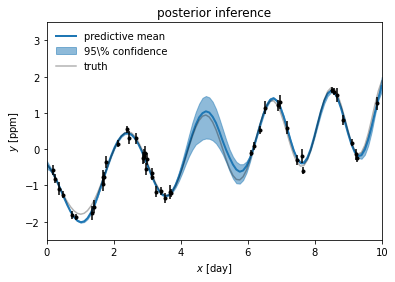

In [16]:
pred_blackjax = jax.vmap(sample_mean, in_axes=(0, None, None, None))(states.position, x, y, x_test)
plot_with_confidence(pred_blackjax, "gp-kernel-opt-blackjax-nuts")